In [1]:
import numpy as np
import polytope as pc
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import OrderedDict

import time
import sys
sys.path.append('../')

from best.mdp import MDP, ParallelMDP
from best.ltl import solve_ltl_cosafe
from best.abstraction import Abstraction

ROVER_STEPS = 15   # rover num of steps
COPTER_STEPS = 30  # copter num of steps
rover_init = np.array([0.5, -4.5])
copter_final = np.array([1.5, -1.5, 2])
copter_init = np.array([-0.5, -4.5, 2])

copter_sight = 2

###### ROVER MODEL (deterministic for now..) ######
rover_abs = Abstraction([-5, -5], [5, 5], [10, 10])
rover = rover_abs.mdp

print rover

Using numpy backend.


MDP: 5 inputs "a" --> 100 outputs "xc"


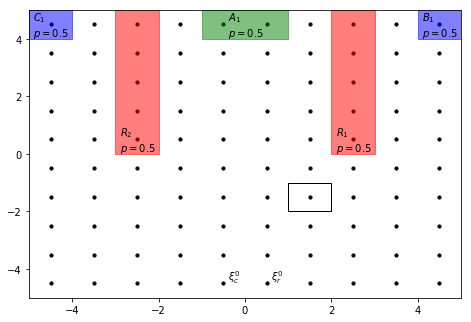

In [2]:
# Define regions
regs = OrderedDict()

regs['r1'] = (pc.box2poly(np.array([[2, 3], [0, 5]])), 0.5, 'red')
regs['r2'] = (pc.box2poly(np.array([[-3, -2], [0, 5]])), 0.5, 'red')
regs['a1'] = (pc.box2poly(np.array([[-1, 1], [4, 5]])), 0.5, 'green')
regs['b1'] = (pc.box2poly(np.array([[4, 5], [4, 5]])), 0.5, 'blue')
regs['c1'] = (pc.box2poly(np.array([[-5, -4], [4, 5]])), 0.5, 'blue')

pinit = [0 if  reg[1] in [0,1] else 2 for reg in regs.itervalues()]

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
fig.add_axes(ax)
rover_abs.plot(ax)
          
def plot_region(poly, name, prob, color='red', alpha=0.5, hatch=False, fill=True):
    ax.add_patch(patches.Polygon(pc.extreme(poly), color=color, alpha=alpha, hatch=hatch, fill=fill))
    _, xc = pc.cheby_ball(poly)
    ax.text(xc[0]-0.4, xc[1]-0.43, '${}_{}$\n$p={}$'.format(name[0].upper(), name[1], prob))

for name, info in regs.iteritems():
    plot_region(info[0], name, info[1], info[2])
    
ax.text(rover_init[0]+0.1, rover_init[1]+0.1, '$\\xi_r^0$')

ax.add_patch(patches.Rectangle( copter_final[:2]-0.5, 1, 1, fill=False ))
ax.text(copter_init[0]+0.1, copter_init[1]+0.1, '$\\xi_c^0$')

fig.savefig('arena.pdf')


In [3]:
## Environment belief model
def get_mdp(p0, qw, name):
    # Create map belief MDP with prior p0 and qw quality of weak measurements
    if p0 == 0:
        # no dynamics
        Tnone = np.array([1])
        Tweak = np.array([1])
        Tstrong = np.array([1])
        output_fcn = lambda s: 0
    
    elif p0 == 1:
        Tnone = np.array([1])
        Tweak = np.array([1])
        Tstrong = np.array([1])
        output_fcn = lambda s: 1
        
    else:
        pm = p0/2
        pp = p0 + (1-p0)/2
        # levels [0 p- p0 p+ 1]

        Tnone = np.eye(5);
        Tweak = np.array([[1,           0,             0,       0,              0], 
                          [qw*(1-pm),   (1-qw)*(1-pm), 0,       (1-qw)*pm,      qw*pm],
                          [qw*(1-p0),   (1-qw)*p0,     0,       (1-qw)*(1-p0),  qw*p0],
                          [qw*(1-pp),   (1-qw)*(1-pp), 0,       (1-qw)*pp,      qw*pp],
                          [0,           0,             0,       0,              1]])
        Tstrong = np.array([[1,      0, 0, 0, 0],
                            [(1-pm), 0, 0, 0, pm],
                            [(1-p0), 0, 0, 0, p0],
                            [(1-pp), 0, 0, 0, pp],
                            [0,      0, 0, 0, 1]])

        def output_fcn(s):
            return [0, pm, p0, pp, 1][s]
    
    return MDP([Tnone, Tweak, Tstrong], input_name=name+'_u', output_name=name+'_b', output_fcn=output_fcn)

env = ParallelMDP([get_mdp(info[1], 0, name) for (name, info) in regs.iteritems()])

print env

MDP: 243 inputs "(r1_u, r2_u, a1_u, b1_u, c1_u)" --> 3125 outputs "(r1_b, r2_b, a1_b, b1_b, c1_b)"


In [4]:
## Connect Rover-env
def conn_rov_env(xr):
    ret = [0 for i in range(len(regs))]
    i = 0
    for (name, info) in regs.iteritems():
        poly = info[0]
        if np.all(poly.A.dot(xr) < poly.b + 2):
            ret[i] = 2    # strong measurement
        i += 1
    return set([tuple(ret)])

rover_env_mdp = rover.product(env, connection=conn_rov_env)
print rover_env_mdp

MDP: 5 inputs "a" --> 312500 outputs "(xc, (r1_b, r2_b, a1_b, b1_b, c1_b))"


In [5]:
## Set up LTL problem

formula = '( ( ! fail U sampleA ) & ( ! fail U sampleB ) ) | ( ! fail U ( emptyA & sampleC ) )'

# map ((xc, ry), (e1, ..., en)) -> 2^2^{sampleA, sampleB, fail}
def ltl_connection(xc_env):
    xc = np.array(xc_env[0]).reshape(2,1)
    env = xc_env[1]
    
    i = 0
    
    ret = set([])
    
    for (name, info) in regs.iteritems():
        poly = info[0]
        
        if name[0] == 'r' and poly.contains(xc) and env[i] > 0:
            # we are in risk reg that is not confirmed safe 
            ret |= set(['fail'])
            
        if name[0] == 'a' and poly.contains(xc) and env[i] == 1:
            # we are in target reg with confirmed sample
            ret |= set(['sampleA'])

        if name[0] == 'b' and poly.contains(xc) and env[i] == 1:
            # we are in target reg with confirmed sample
            ret |= set(['sampleB'])

        if name[0] == 'c' and poly.contains(xc) and env[i] == 1:
            # we are in target reg with confirmed sample
            ret |= set(['sampleC'])
        i += 1

    if env[2] == 0:
        # no sample A
        ret |= set(['emptyA'])

    return set([tuple(ret)])

In [6]:
rover_ltlpol = solve_ltl_cosafe(rover_env_mdp, formula, ltl_connection, delta=0.001, maxiter=ROVER_STEPS, verbose=True)

iteration 0, time 0.000216007232666
iteration 1, time 9.39843606949
iteration 2, time 17.9756140709
iteration 3, time 26.3831751347
iteration 4, time 34.8393461704
iteration 5, time 43.2400290966
iteration 6, time 51.6118631363
iteration 7, time 59.9359881878
iteration 8, time 68.9568150043
iteration 9, time 77.4662780762
iteration 10, time 86.0465190411
iteration 11, time 94.5769300461
iteration 12, time 103.156517029
iteration 13, time 111.870164156
iteration 14, time 120.350555182
finished after 128.8782022s and 15 iterations


success probability: 0.241


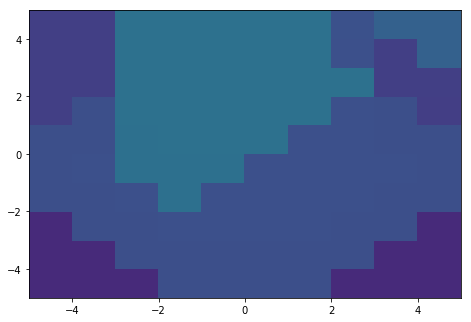

In [7]:
def my_value(x, mapstate):    
    s_abstr = rover_abs.x_to_s(np.array(x).flatten())
    s_tot = rover_env_mdp.global_state( (s_abstr, mapstate) )

    _, val = rover_ltlpol.get_input(s_tot)
    return val

def my_init_value(x, y):
    return my_value(np.array([x, y]), pinit)

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))
vals = np.vectorize(my_init_value)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals, vmin=0, vmax=1)

print 'success probability: {}'.format(my_value(rover_init, pinit))

fig.savefig('value-rov.pdf')

In [8]:
# Copter system
copter_abstr = Abstraction([-5, -5, 1.5], [5, 5, 3.5], [10, 10, 2])

copter = copter_abstr.mdp

print copter

# connect copter with map
def is_above(poly, x):
    # return true x within distance 1 of func
    return poly.contains(x.reshape((2,1)))

def is_adjacent(poly, x):
    # return true x within distance 3 of func
    return np.all(poly.A.dot(x) < poly.b + copter_sight)

def copt_env(xr):
    ret = [0 for i in range(len(regs))]
    i = 0
    for (name, info) in regs.iteritems():
        if is_above(info[0], xr[0:2]) and xr[2] < 2.5:
            ret[i] = 2    # strong measurement
        elif is_adjacent(info[0], xr[0:2]) and xr[2] > 2.5:
            ret[i] = 1    # weak measurement
        i += 1
        
    return set([tuple(ret)])

mdp_copt_env = copter.product(env, connection=copt_env)
print mdp_copt_env

MDP: 7 inputs "a" --> 200 outputs "xc"
MDP: 7 inputs "a" --> 625000 outputs "(xc, (r1_b, r2_b, a1_b, b1_b, c1_b))"


In [9]:
# value function at time t: rover success entropy * copter safe
margin = 0.05

VT = -np.inf * np.ones(mdp_copt_env.N_list)

v_max = np.max(rover_ltlpol.V.flatten())

init_val = my_value(rover_init, pinit)

for n in range(copter.N):
    if n == copter_abstr.x_to_s(np.array(copter_final)):   # if safe
        for m in range(env.N):
            maps = env.local_states(m)
            v = my_value( rover_init, maps )
            VT[n, m] = 1 if (v > v_max-margin or v < margin) else 0

In [10]:
# run value iteration
V_copt, Pol_copt = mdp_copt_env.solve_reach(VT, maxiter=COPTER_STEPS, delta=0.001, verbose=True)

iteration 0, time 0.000648975372314
iteration 1, time 1.91232204437
iteration 2, time 3.84777188301
iteration 3, time 5.89511704445
iteration 4, time 7.90119194984
iteration 5, time 9.88001799583
iteration 6, time 11.8895740509
iteration 7, time 13.8358669281
iteration 8, time 15.7939879894
iteration 9, time 17.9575839043
iteration 10, time 20.0639989376
iteration 11, time 22.0827710629
iteration 12, time 24.0751669407
iteration 13, time 26.0261480808
iteration 14, time 27.9388790131
iteration 15, time 29.895113945
iteration 16, time 31.9943668842
iteration 17, time 33.9496080875
iteration 18, time 35.9112999439
iteration 19, time 37.8628900051
iteration 20, time 39.8144659996
iteration 21, time 41.7916829586
iteration 22, time 43.7337300777
iteration 23, time 45.6566009521
iteration 24, time 47.5898640156
iteration 25, time 49.5486299992
iteration 26, time 51.53302598
iteration 27, time 53.4879460335
iteration 28, time 55.4521279335
iteration 29, time 57.384428978
finished after 59.32

success value: 0.977


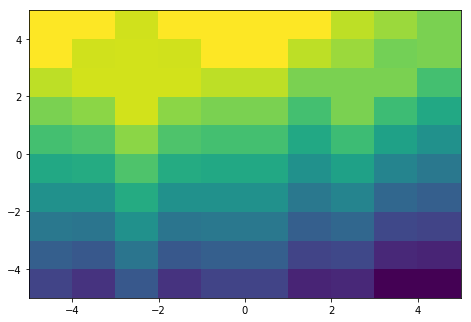

In [11]:
import matplotlib
    
def copter_value(x, mapstate):  
    scop = copter_abstr.x_to_s(x)
    
    stot = mdp_copt_env.global_state((scop, mapstate))

    return V_copt[stot]

def my_init_cvalue(x, y):
    return copter_value(np.array([x, y, 2]), pinit)

fig = plt.figure()
ax = plt.Axes(fig, [0.,0.,1.,1.])
# ax.set_axis_off()
fig.add_axes(ax)

x, y = np.meshgrid(np.arange(-5, 6, 1), np.arange(-5, 6, 1))
xx, yy = np.meshgrid(np.arange(-5, 5, 1), np.arange(-5, 5, 1))

vals = np.vectorize(my_init_cvalue)(xx+0.5, yy+0.5)

ax.pcolor(x, y, vals)

print 'success value: {}'.format(copter_value(np.array(copter_init), pinit))

In [12]:
# Control policies

class RoverPolicy:
    
    def __init__(self, ltlpol):
        self.ltlpol = ltlpol
    
    def __call__(self, x, mapstate):
        aps = ltl_connection((x, env.output( env.global_state(mapstate) )))
        rover_ltlpol.report_aps(list(aps)[0])

        s_ab = rover_abs.x_to_s(x)

        s_tot = rover_env_mdp.global_state((s_ab, mapstate))
        u_ab, curr_val = rover_ltlpol.get_input(s_tot)

        return rover_abs.interface(u_ab, s_ab, x)
    
    def finished(self):
        return self.ltlpol.finished()
    
    def reset(self):
        self.ltlpol.reset()    

class CopterPolicy:
    
    def __init__(self, pol):
        self.pol = pol
        self.ft = False
            
    def __call__(self, x, mapstate):
                
        s_ab = copter_abstr.x_to_s(x)
        s_map = env.global_state(mapstate)
        s_tot = mdp_copt_env.global_state((s_ab, mapstate))
    
        if VT[s_ab, s_map] == 1:
            self.ft = True
            u_ab = 0
        else:
            u_ab = self.pol[s_tot]

        return copter_abstr.interface(u_ab, s_ab, x)
    
    def reset(self):
        self.ft = False
    
    def finished(self):
        return self.ft
            
copter_policy = CopterPolicy(Pol_copt)
rover_policy = RoverPolicy(rover_ltlpol)

success probability: 0.987
mapstate: [0, 2, 4, 4, 2]
success probability: 0.986
mapstate: [2, 4, 0, 2, 4]
success probability: 0.0
mapstate: [4, 2, 4, 2, 2]
success probability: 0.0
mapstate: [0, 2, 4, 0, 2]


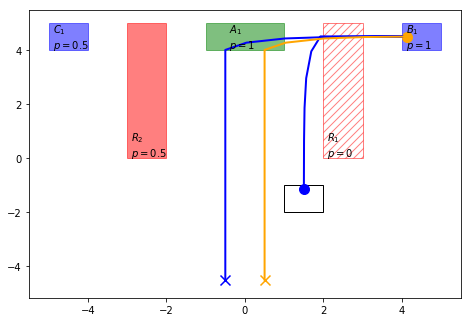

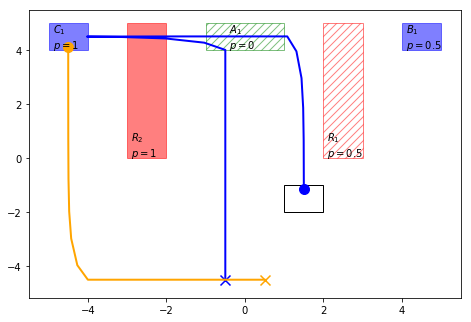

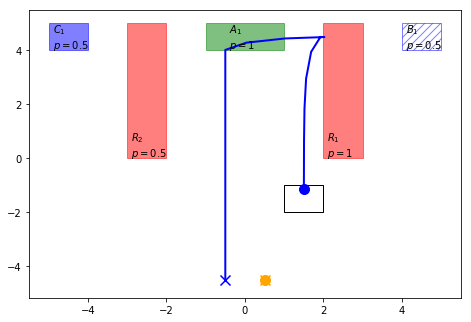

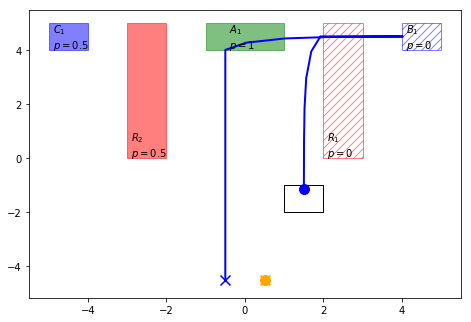

In [13]:
# Simulations

realmaps = ([0, 4, 4, 4, 4], [0, 4, 0, 4, 4], [4, 4, 4, 0, 4], [0, 4, 4, 0, 4])   # true map state

for exp_i in range(len(realmaps)):
    
    realmap = realmaps[exp_i][:]
    
    mapstate = pinit[:]
    
    rover_policy.reset()
    copter_policy.reset()

    # copter simulation
    x_copter = np.array(copter_init).reshape((1,3))
    while not copter_policy.finished():

        x_curr = x_copter[-1, :].flatten()

        map_meas = list(copt_env(x_curr))[0]

        for i in range(len(map_meas)):
            if mapstate[i] in [0, 4]:
                continue
            if map_meas[i] == 1:  # weak meas
                if realmap[i] == 4:
                    mapstate[i] = 3
                else:
                    mapstate[i] = 1
            if map_meas[i] == 2:
                mapstate[i] = realmap[i]

        x_next = copter_policy(x_curr, mapstate)

        x_del = x_curr + 0.1*(x_next - x_curr)/np.linalg.norm(x_next - x_curr)
        x_copter = np.vstack([x_copter, x_del])
        
    print 'success probability: {}'.format(my_value(rover_init, mapstate))
    print 'mapstate: {}'.format(mapstate)
        
    env_probs = env.output(env.global_state(mapstate))

    # rover simulation
    it = 0
    x_rover = np.array(rover_init).reshape((1,2))
    while not rover_policy.finished() and it < 200:
        
        x_curr = x_rover[-1, :].flatten()
        
        map_meas = list(conn_rov_env(x_curr))[0]
        for i in range(len(map_meas)):
            if map_meas[i] == 2:  # strong meas
                mapstate[i] = realmap[i]
        
        x_next = rover_policy(x_curr, mapstate)
        
        if np.linalg.norm(x_next - x_curr) > 0:
            x_del = x_curr + 0.1*(x_next - x_curr)/np.linalg.norm(x_next - x_curr)
        else:
            x_del = x_curr
        x_rover = np.vstack([x_rover, x_del])
        
        it += 1

    fig = plt.figure()
    ax = plt.Axes(fig, [0.,0.,1.,1.])
    fig.add_axes(ax)
    
    i = 0
    for (name, info) in regs.iteritems():
        if realmap[i] == 0:
            hatch = '///'
            fill = False
        else:
            hatch = False
            fill = True
        plot_region(info[0], name, env_probs[i], info[2], hatch=hatch, fill=fill)
        i += 1

    ax.plot(x_copter[:, 0], x_copter[:, 1], color='blue', linewidth=2)
    ax.scatter(x_copter[0, 0], x_copter[0, 1], marker='x', color='blue', zorder=2, s=100)
    ax.scatter(x_copter[-1, 0], x_copter[-1, 1], marker='o', color='blue', zorder=2, s=100)

    ax.plot(x_rover[:, 0], x_rover[:, 1], color='orange', linewidth=2)
    ax.scatter(x_rover[0, 0], x_rover[0, 1], marker='x', color='orange', zorder=2, s=100)
    ax.scatter(x_rover[-1, 0], x_rover[-1, 1], marker='o', color='orange', zorder=2, s=100)

    ax.add_patch(patches.Rectangle( copter_final[:2]-0.5, 1, 1, fill=False ))

    fig.savefig('exp{}-map.pdf'.format(exp_i))